In [1]:
import sys
import os

# Add project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.chdir(project_root)

In [2]:
# === Imports ===
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix, 
    calculate_hierarchical_prediction_distribution, 
    plot_stacked_percentage_bar_chart,
)
from mmengine import Config
from mmengine.fileio import load
from mmengine.registry import init_default_scope
from mmdet.registry import DATASETS
from mmdet.utils import update_data_root
from hod.utils.tree import HierarchyTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# === Configuration ===
# Define the models to analyze. Add a new entry for each model you want to compare.
MODELS_TO_ANALYZE = {
    "DINO": {
        "config_path": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func.pkl" # <-- SET MANUALLY
    },
    "DINO-E (S)": {
        "config_path": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.pkl" # <-- SET MANUALLY
    },
    # "DINO-H (M) \ndecay=2": {
    #     "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func.py",
    #     "prediction_path": "outputs/inference/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func-multi.pkl"
    # },
    
    "DINO-H (S) \ndecay=2": {
        "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func-single.pkl"
    },
    "DINO-H (S) \ndecay=10": {
        "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-single.pkl"
    },
    "DINO-H (M) \ndecay=10": {
        "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-multi.pkl"
    },
}

# --- Analysis Parameters ---
# Score threshold for filtering detections
score_thr = 0.3

# IoU threshold for matching predictions to ground truth
tp_iou_thr = 0.5

In [4]:
# === Process Models ===
# This cell iterates through each model defined in the configuration, calculates the 
# hierarchical statistics, and stores them for plotting.

all_model_stats = {}

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config_path']
    prediction_path = model_info['prediction_path']

    # --- Load Config and Dataset ---
    cfg = Config.fromfile(config_path)
    update_data_root(cfg)
    init_default_scope(cfg.get('default_scope', 'mmdet'))
    dataset = DATASETS.build(cfg.test_dataloader.dataset)

    # --- Load Prediction Results ---
    results = load(prediction_path)

    # --- Calculate Confusion Matrix ---
    confusion_matrix = calculate_confusion_matrix(
        dataset,
        results,
        score_thr=score_thr,
        tp_iou_thr=tp_iou_thr
    )

    # --- Generate Hierarchical Distribution ---
    stats = calculate_hierarchical_prediction_distribution(
        dataset,
        confusion_matrix,
        verbose=False
    )
    
    # Store only the total stats for comparison
    all_model_stats[model_name] = stats['Total']

print("\nAll models processed.")

Processing model: DINO...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15700.78img/s]


Processing model: DINO-E (S)...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15315.06img/s]


Processing model: DINO-H (S) 
decay=2...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15603.18img/s]


Processing model: DINO-H (S) 
decay=10...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15567.18img/s]


Processing model: DINO-H (M) 
decay=10...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10801.01img/s]


All models processed.


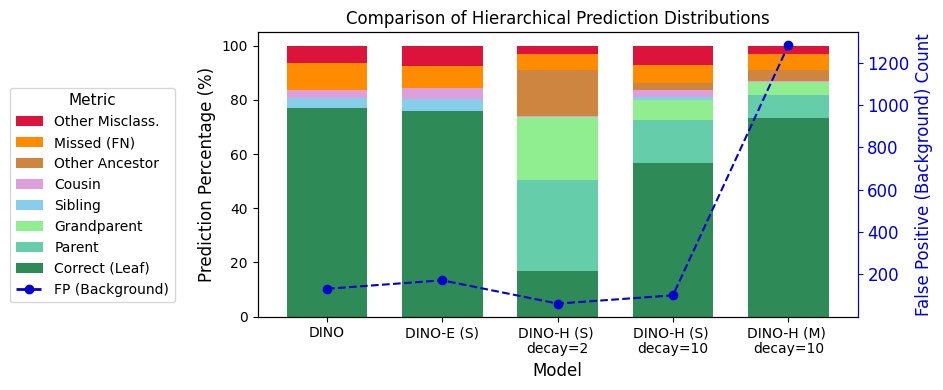

In [5]:
# === Plot Comparative Hierarchical Distribution ===
# This step converts the collected statistics into a pandas DataFrame and plots a
# stacked bar chart to compare the hierarchical prediction distribution across all models,
# with the False Positive (Background) counts overlaid as a line plot.

if all_model_stats:
    # Convert the stats dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(all_model_stats, orient='index')

    # --- Define Plotting Order, Labels, and Colors ---
    # Use the same definitions as the robustness notebook for consistency
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    
    plot_labels = {
        'tp_percentage': 'Correct (Leaf)',
        'parent_percentage': 'Parent',
        'grandparent_percentage': 'Grandparent',
        'sibling_percentage': 'Sibling',
        'cousin_percentage': 'Cousin',
        'ancestor_percentage': 'Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclass.',
        'fp_bg': 'FP (Background)'
    }

    plot_colors = {
        'tp_percentage': '#2E8B57',
        'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90',
        'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD',
        'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00',
        'other_class_percentage': '#DC143C',
        'fp_bg': '#0000CD' # Add color for fp_bg
    }

    # Filter out any metrics that are not present in the DataFrame and rename for plot
    available_metrics = [metric for metric in plot_order if metric in df.columns]
    df_plot = df[available_metrics].rename(columns=plot_labels)
    plot_order_labels = [plot_labels[metric] for metric in available_metrics]
    color_order = [plot_colors[metric] for metric in available_metrics]

    # --- Create Stacked Bar Chart for Percentages (no broken y-axis) ---
    fig, ax = plt.subplots(figsize=(9, 4))

    df_plot[plot_order_labels].plot(
        kind='bar',
        stacked=True,
        color=color_order,
        width=0.7,
        ax=ax,
        legend=False
    )

    ax.set_ylabel('Prediction Percentage (%)', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_title('Comparison of Hierarchical Prediction Distributions', fontsize=12)
    # Make x-axis (model) labels slanted for better visibility
    ax.tick_params(axis='x', labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    # --- Create Line Plot for FP (Background) Counts on a secondary y-axis ---
    if 'fp_bg' in df.columns:
        ax2 = ax.twinx()
        fp_bg_color = plot_colors['fp_bg']
        df['fp_bg'].plot(
            kind='line',
            marker='o',
            color=fp_bg_color,
            ax=ax2,
            linestyle='--',
            legend=False
        )
        ax2.set_ylabel('False Positive (Background) Count', fontsize=12, color=fp_bg_color)
        ax2.tick_params(axis='y', labelsize=12, colors=fp_bg_color)
        ax2.spines['right'].set_color(fp_bg_color)
        ax2.grid(False)

    # --- Combine Legends and place at the left as a single column ---
    h1, l1 = ax.get_legend_handles_labels()
    if 'fp_bg' in df.columns:
        from matplotlib.lines import Line2D
        h2 = [Line2D([0], [0], color=plot_colors['fp_bg'], lw=2, ls='--', marker='o')]
        l2 = [plot_labels['fp_bg']]
        handles = list(reversed(h1)) + h2
        labels = list(reversed(l1)) + l2
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.15, 0.5), ncol=1, title='Metric', fontsize=10, title_fontsize=11)
    else:
        handles = reversed(h1)
        labels = reversed(l1)
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.15, 0.5), ncol=1, title='Prediction Type', fontsize=10, title_fontsize=11)

    plt.tight_layout(rect=[0.05, 0, 0.9, 1])
    plt.show()

else:
    print("No model statistics were generated. Please check the configuration and processing steps.")

In [6]:
# === Display Statistics Table ===
# Print the DataFrame as a formatted table for easy copying.
if all_model_stats:
    display(df)
else:
    print("No model statistics were generated.")

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,fp_bg,tp_percentage,parent_percentage,grandparent_percentage,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class
DINO,2297.0,1766.0,0.0,0.0,87.0,71.0,0.0,0.0,230.0,132.0,76.882891,0.000000,0.000000,3.787549,3.090988,0.000000,10.013061,6.225512,0.000000,143.0
DINO-E (S),2297.0,1745.0,0.0,0.0,102.0,94.0,0.0,0.0,184.0,172.0,75.968655,0.000000,0.000000,4.440575,4.092294,0.000000,8.010448,7.488028,0.000000,172.0
DINO-H (S) \ndecay=2,2297.0,385.0,777.0,532.0,2.0,8.0,389.0,3194.0,138.0,62.0,16.760993,33.826731,23.160644,0.087070,0.348280,16.935133,6.007836,2.873313,1.881037,66.0
DINO-H (S) \ndecay=10,2297.0,1299.0,372.0,164.0,28.0,57.0,60.0,908.0,154.0,101.0,56.552024,16.195037,7.139747,1.218981,2.481498,2.612103,6.704397,7.096212,1.523490,163.0
DINO-H (M) \ndecay=10,2297.0,1681.0,196.0,113.0,2.0,8.0,89.0,708.0,140.0,1282.0,73.182412,8.532869,4.919460,0.087070,0.348280,3.874619,6.094906,2.960383,1.778894,68.0
